In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pathlib import Path
from zipfile import ZipFile
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from numba import jit
import cvxpy as cp

from utils.PathManager import PathManager
from utils.RawDataLoader import RawDataLoader
from utils.ProcessedDataLoader import ProcessedDataLoader
from utils.DataProcessor import DataProcessor
from helper.DataProcessorHelper import DataProcessorHelper
from utils.AlphaCalculator import AlphaCalculator
from utils.AlphaPerformanceAnalyzer import AlphaPerformanceAnalyzer


# 1. Configuration: configure Base Data Path

All paths are encapsulated in PathManager().   
First, create an instance of PathManager class.     
Second, set the base data path to the base folder (e.g. ./data). Then, data path can be retrieved by PathManager.get()

In [2]:
# Create an instance of the PathManager class
path_manager = PathManager()

# Set the base data path
new_base_path = r"C:\Users\daiyu\OneDrive\github-upload\data"
path_manager.set_base_data_path(new_base_path)

# Print the updated base data path to confirm the change
print("Updated Base Data Path:", path_manager.base_data_path)

# All paths are encapsulated in PathManager()
# PathManager.path_manager(tab_name) can retrieve the relevant data path
# Get a specific data path to see how it reflects the new base path
data_path = path_manager.get('adj_fct')
print("Updated Path for 'adj_fct':", data_path)


Updated Base Data Path: C:\Users\daiyu\OneDrive\github-upload\data
Updated Path for 'adj_fct': C:\Users\daiyu\OneDrive\github-upload\data\Raw data\other\adj_fct


# 2. Load Raw Data

### RawDataLoader
The RawDataLoader class can load raw data.   
First, create an instance of the RawDataLoader class.   
Then, raw data can be loaded by RawDataLoader.loading(data_name, start_date, end_date).   
Raw data can also be loaded on a rolling basis by RawDataLoader.loading_with_window(data_name, start_date, rolling_window)


### Raw Data Description
- **qishi_1min**: 
  - All market stock minute-level data, saved by trading day, individual stock file.
  
- **adj_fct**: 
  - Cumulative adjustment factors, saved by trading day, daily individual file.
  
- **idx**: 
  - Main index daily price and volume data, saved by trading day.
  - Includes Shanghai Composite Index, CSI 300, CSI 500/800/1000, Shenzhen GEM Index, Shenzhen Composite Index.
  
- **lmt**: 
  - lmt contains daily limit-up and limit-down prices for individual stocks, saved by trading day.
  - 涨停板 (Limit-Up Price): This refers to the maximum price increase limit that a stock can reach during a single trading day. In the A-share market, this limit is typically set at 10% above the previous day's closing price for most stocks 
  - 跌停板 (Limit-Down Price): This refers to the maximum price decrease limit that a stock can experience during a single trading day. In the A-share market, this limit is usually set at 10% below the previous day's closing price for most stocks

- **mkt_val**: 
  - Stock market capitalization, total market value, circulating capital stock, total capital stock, saved by trading day.
  
- **sw**: 
  - Shenwan industry classification, saved by trading day.
  
- **univ**: 
  - `hs300`: CSI 300 constituent stocks.
  - `zz500`: CSI 500 constituent stocks.
  - `zz800`: CSI 800 constituent stocks.
  - `zz1000`: CSI 1000 constituent stocks.
  - `zz9999`: CSI All-Share constituent stocks.


In [3]:
# ======================================================================
# Example: Load Raw Daily Data

# Create an instance of the RawDataLoader class
data_loader = RawDataLoader()

# Load daily data
# configure which data to load
tab_name = 'mkt_val' #other choices for tab_name：adj_fct, lmt, mkt_val, sw, hs300, zz500, zz800, zz1000, zz9999,idx
result = data_loader.loading(tab_name, '2018-12-25', '2018-12-30')
result.head()

Loading data from C:\Users\daiyu\OneDrive\github-upload\data\Raw data\other\mkt_val


,code,date,neg_mkt_val,mkt_val,neg_shares,shares
0,1,20181225,1.603701e+11,1.603716e+11,1.717025e+10,1.717041e+10
1,2,20181225,2.328726e+11,2.646085e+11,9.715170e+09,1.103915e+10
2,4,20181225,1.342323e+09,1.357903e+09,8.301320e+07,8.397670e+07
3,5,20181225,2.625374e+09,2.921562e+09,9.512225e+08,1.058537e+09
4,6,20181225,6.970752e+09,6.979475e+09,1.348308e+09,1.349995e+09


In [10]:
# ======================================================================
# Example: Load raw daily data in a rolling base
tab_name = 'mkt_val' #other choices for tab_name：adj_fct, lmt, mkt_val, sw, hs300, zz500, zz800, zz1000, zz9999,idx
result = data_loader.loading_with_window(tab_name, '2018-04-09', 10) # This will load data for adj_fct from 10 days before April 9, 2018
result.head()   


Searching for available dates in C:\Users\daiyu\OneDrive\github-upload\data\Raw data\other\mkt_val
Loading mkt_val data from 2018-03-22 to 2018-04-09
Loading data from C:\Users\daiyu\OneDrive\github-upload\data\Raw data\other\mkt_val


,code,date,neg_mkt_val,mkt_val,neg_shares,shares
0,1,20180322,1.972637e+11,2.002070e+11,1.691798e+10,1.717041e+10
1,2,20180322,3.029190e+11,3.442008e+11,9.715170e+09,1.103915e+10
2,4,20180322,1.884400e+09,1.906271e+09,8.301320e+07,8.397670e+07
3,5,20180322,3.728792e+09,4.149465e+09,9.512225e+08,1.058537e+09
4,6,20180322,1.059738e+10,1.061096e+10,1.348267e+09,1.349995e+09


In [5]:
# ======================================================================
# Example: Load raw minute level data
tab_name = '1min_pv' 
result = data_loader.loading('1min_pv', '2018-01-03', '2018-01-05')
result.head()  


Loading data from C:\Users\daiyu\OneDrive\github-upload\data\Raw data\qishi_1min


,code,date,time,pre_close,open,high,low,close,volume,turover,dif_mi,accvolume,accturover,match_items
0,1,20180103,930,137000,137300,137600,136600,136700,3323800,45648773,865,3323800,45648773,865
1,1,20180103,931,137000,136700,136700,136400,136500,655187,8946838,382,3978987,54595611,1247
2,1,20180103,932,137000,136600,137100,136500,137100,573229,7838282,279,4552216,62433893,1526
3,1,20180103,933,137000,137100,137300,137000,137000,1390571,19071471,317,5942787,81505364,1843
4,1,20180103,934,137000,137000,137000,136400,136500,908100,12407225,348,6850887,93912589,2191


# 3. Process Raw Data 

### 3.1 Process Daily Data

The `load_and_process()` function will:
1. Load the raw data
2. Process the data: data cleaning, adjust the price for splits, etc.
3. Format the data uniformly
4. Store the processed files

For all stock daily data (`adj_fct`, `lmt`, `mkt_val`, `sw`, `hs300`, `zz500`, `zz800`, `zz1000`, `zz9999`, `idx`), each column will be stored individually.  
Each column will be reformatted into a structure with `code`, `date`, `val`, and `item`, and then saved in the folder: ./data/Processed data/stock_data_daily.   
Each column will be treated as a distinct item, and the corresponding information will be automatically added to the `items` table for easy search and retrieval in the future.

In [3]:
# ======================================================================
# Example: Process the raw daily stock data

# Create an instance of the DataProcessor class
data_processor = DataProcessor()

# Process the raw daily stock data
data = data_processor.load_and_process('adj_fct', '2018-01-03', '2018-12-28')
data = data_processor.load_and_process('lmt', '2018-01-03', '2018-12-28')
data = data_processor.load_and_process('mkt_val', '2018-01-03', '2018-12-28')
data = data_processor.load_and_process('sw', '2018-01-03', '2018-12-28')
data = data_processor.load_and_process('hs300', '2018-01-03', '2018-12-28')
data = data_processor.load_and_process('zz500', '2018-01-03', '2018-12-28')
data = data_processor.load_and_process('zz800', '2018-01-03', '2018-12-28')
data = data_processor.load_and_process('zz1000', '2018-01-03', '2018-12-28')
data = data_processor.load_and_process('zz9999', '2018-01-03', '2018-12-28')
data = data_processor.load_and_process('idx', '2018-01-03', '2018-12-28')




Loading data.
Loading data from C:\Users\daiyu\OneDrive\github-upload\data\Raw data\other\adj_fct
Processing data.
Saving data
Loading data.
Loading data from C:\Users\daiyu\OneDrive\github-upload\data\Raw data\other\lmt
Processing data.
Saving data
Loading data.
Loading data from C:\Users\daiyu\OneDrive\github-upload\data\Raw data\other\mkt_val
Processing data.
Saving data
Loading data.
Loading data from C:\Users\daiyu\OneDrive\github-upload\data\Raw data\other\sw
Processing data.
Saving data
Loading data.
Loading data from C:\Users\daiyu\OneDrive\github-upload\data\Raw data\other\univ\hs300
Processing data.
Saving data
Loading data.
Loading data from C:\Users\daiyu\OneDrive\github-upload\data\Raw data\other\univ\zz500
Processing data.
Saving data
Loading data.
Loading data from C:\Users\daiyu\OneDrive\github-upload\data\Raw data\other\univ\zz800
Processing data.
Saving data
Loading data.
Loading data from C:\Users\daiyu\OneDrive\github-upload\data\Raw data\other\univ\zz1000
Processin

### 3.2 Aggregate Minute-level Stock Data

The `load_and_aggregate()` function will:
1. Load the raw data
2. Process the data: data cleaning, adjust the price for splits, etc.
3. Aggregate the minute-level data to daily data: The aggregation method is determined by the `func` parameter
4. Format the data uniformly
5. Store the processed files

For all minute-level stock data (`1min_pv`), the selected column will be aggregated and stored individually.  
Each column will be reformatted into a structure with `code`, `date`, `time`, `val`, and `item`, and then saved in the folder: ./data/Processed data/stock_data_daily   
Each column will be treated as a distinct item, and the corresponding information will be automatically added to the `items` table for easy search and retrieval in the future.

In [ ]:
# ======================================================================
# Example: Aggregate the raw minute-level stock data

# Stock minute-level data can also be aggregated into daily data.
# The aggregation method is determined by the `func` parameter, with the default methods being ['mean', 'std'].
# Custom methods can also be specified.

def first(x): x.iloc[0]
def last(x): x.iloc[-1]
data = data_processor.load_and_aggregate('1min_pv', '2018-01-03', '2018-12-28',  fields = ['code','date','time','open'], func= ['first'])
data = data_processor.load_and_aggregate('1min_pv', '2018-01-03', '2018-12-28',  fields = ['code','date','time','high'], func= ['max'])
data = data_processor.load_and_aggregate('1min_pv', '2018-01-03', '2018-12-28',  fields = ['code','date','time','low'], func= ['min'])
data = data_processor.load_and_aggregate('1min_pv', '2018-01-03', '2018-12-28',  fields = ['code','date','time','close'], func= ['last'])
data = data_processor.load_and_aggregate('1min_pv', '2018-01-03', '2018-12-28',  fields = ['code','date','time','accvolume'], func= ['last'])
data = data_processor.load_and_aggregate('1min_pv', '2018-01-03', '2018-12-28',  fields = ['code','date','time','accturover'], func= ['last'])





### 3.3 Load Processed Data

In [4]:
data_loader_processed = ProcessedDataLoader()

# ======================================================================
# Load Processed Daily data
tab_name = 'up_limit' 
result = data_loader_processed.loading(tab_name, '2018-01-03', '2018-01-05')
result.head() 

Loading data from C:\Users\daiyu\OneDrive\github-upload\data\Processed data\stock_data_daily\up_limit


,code,date,val,item
0,1,20180103,15.07,up_limit
1,2,20180103,35.82,up_limit
2,4,20180103,24.57,up_limit
3,5,20180103,4.75,up_limit
4,6,20180103,10.84,up_limit


In [5]:
# ======================================================================
# Load Processed Daily data in a rolling basis
tab_name = 'up_limit' 
result = data_loader_processed.loading_with_window(tab_name, '2018-01-08', 2)
result.head()

Searching for available dates in C:\Users\daiyu\OneDrive\github-upload\data\Processed data\stock_data_daily\up_limit
Loading up_limit data from 2018-01-04 to 2018-01-08
Loading data from C:\Users\daiyu\OneDrive\github-upload\data\Processed data\stock_data_daily\up_limit


,code,date,val,item
0,1,20180104,14.66,up_limit
1,2,20180104,35.56,up_limit
2,4,20180104,26.18,up_limit
3,5,20180104,4.70,up_limit
4,6,20180104,10.84,up_limit


# 4. Construct Alpha Score and Alpha Portfolio

## How to Construct an Alpha Signal

To construct an alpha signal, follow these steps:

1. **Create an Instance of the `AlphaCalculator` Class**
   - Begin by creating an instance of the `AlphaCalculator` class. This will be used to manage and calculate your alpha signals.

2. **Configure the Alpha Settings**
   - Write and add the necessary configuration to the `alpha_config.yaml` file located in `./data/alpha_config/`.
   - The configuration should include:
     - **Input data**: The data sources required for the alpha calculation.
     - **Start date**: The starting date for the alpha signal calculations.
     - **End date**: The ending date for the alpha signal calculations.
     - **Standardization method**: Specify how the data should be standardized.
     - **Universe**: Define the universe of stocks or assets to be included in the alpha portfolio. A single alpha signal can be applied to a list of universes, resulting in the creation of a corresponding list of alpha portfolios.

3. **Write the Alpha Calculation Script**
   - Write and add the script that calculates the alpha score. This script should be placed in the `./code/alpha/` directory.
   - The script will contain the logic for calculating the alpha signal based on the configuration.

4. **Calculate the Alpha Signals**
   - Use the function `alpha_calculator.calc_alpha([list of alpha names])` to calculate the specified list of alphas.
   - This function will generate the alpha signals based on the configuration and scripts you've set up.

By following these steps, you can construct and calculate custom alpha signals for your trading or investment strategies.


In [39]:
alpha_calculator = AlphaCalculator()
alpha_portfolio_dict = alpha_calculator.calc_alpha(['iamp'])
print(alpha_portfolio_dict)

[{'iamp_zz9999':           code      date       val         item
0            1  20180129 -0.000458  iamp_zz9999
1            1  20180130 -0.000427  iamp_zz9999
2            1  20180131 -0.000608  iamp_zz9999
3            1  20180201 -0.000856  iamp_zz9999
4            1  20180202 -0.000884  iamp_zz9999
...        ...       ...       ...          ...
700361  603999  20181224 -0.001186  iamp_zz9999
700362  603999  20181225 -0.001191  iamp_zz9999
700363  603999  20181226 -0.001174  iamp_zz9999
700364  603999  20181227 -0.001152  iamp_zz9999
700365  603999  20181228 -0.001173  iamp_zz9999

[700366 rows x 4 columns], 'iamp_zz1000':           code      date       val         item
0           10  20180129 -0.003945  iamp_zz1000
1           10  20180130 -0.003794  iamp_zz1000
2           10  20180131 -0.002821  iamp_zz1000
3           10  20180201 -0.001548  iamp_zz1000
4           10  20180202 -0.001126  iamp_zz1000
...        ...       ...       ...          ...
210299  603999  20181224 -0.

# 5. BackTest Alpha

The `AlphaPerformanceAnalyzer` class is designed to evaluate the performance of alpha portfolios

### Features

The main functionality provided by `AlphaPerformanceAnalyzer.analyze_alpha_performance()` method allows for a comprehensive analysis of alpha portfolios over a specified time period. This method accepts the following parameters:

  - `alpha_portfolios`: A list of alpha portfolios, where each portfolio is named in the format `'alpha-name'_'universe-name'`.
  - `start_date`: The start date of the analysis period.
  - `end_date`: The end date of the analysis period.
  - `is_limit_adj`: A boolean indicating whether the price change limits of the China A-share market are to be applied in the backtest. Setting this to `True` applies the price limit adjustments.
  - `rebalance_day`: Specifies the rebalance delay (`delay0`, `delay1`, etc.), where `delay0` means rebalancing on T+0 and `delay1` means rebalancing on T+1.

### Analytical Outputs

The method evaluates and returns comprehensive insights into the alpha portfolios' performance, including:

1. **Performance Metrics**: Overall return, risk, Sharpe ratio, maximum drawdown, and turnover of the alpha portfolio.
2. **Long/Short Performance**: Detailed performance analysis of the long and short legs of the portfolios.
3. **Information Coefficient (IC)**: Measures the predictive skill of the alpha factors.
4. **Return by Percentile**: Analyzes returns across different percentiles to understand performance distribution.
5. **Alpha Decay**: Studies the decay in alpha value over time.
6. **Portfolio Weight Distribution**: Examines the distribution of weights across the portfolio constituents.
7. **Alpha Score Distribution**: Reviews the distribution of alpha scores 


### Example

```python
alpha_analyzer = AlphaPerformanceAnalyzer()
results = alpha_analyzer.analyze_alpha_performance(
    alpha_portfolios=['alpha1_universe1', 'alpha2_universe2'],
    start_date='2021-01-01',
    end_date='2021-12-31',
    is_limit_adj=True,
    rebalance_day='delay1'
)
print(results)


+----+-------------+---------------------+-------------------+-----------------+--------------------+--------------------------+-------------+
|    | alpha       |   annualized_return |   annualized_risk |   annualized_IR |   maximum_drawdown |   average_daily_turnover | portfolio   |
|----+-------------+---------------------+-------------------+-----------------+--------------------+--------------------------+-------------|
|  0 | iamp_zz9999 |            0.312673 |         0.0567657 |         5.50814 |         -0.0167049 |                 0.296489 | all         |
|  0 | iamp_zz9999 |           -0.236023 |         0.274359  |        -0.86027 |         -0.38784   |                 0.133555 | long        |
|  0 | iamp_zz9999 |            0.548696 |         0.267077  |         2.05445 |         -0.121883  |                 0.112336 | short       |
+----+-------------+---------------------+-------------------+-----------------+--------------------+--------------------------+-------------+

c:\Users\daiyu\OneDrive\github-upload\code\utils\AlphaPerformanceAnalyzer.py:59: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  summary_plot.show()


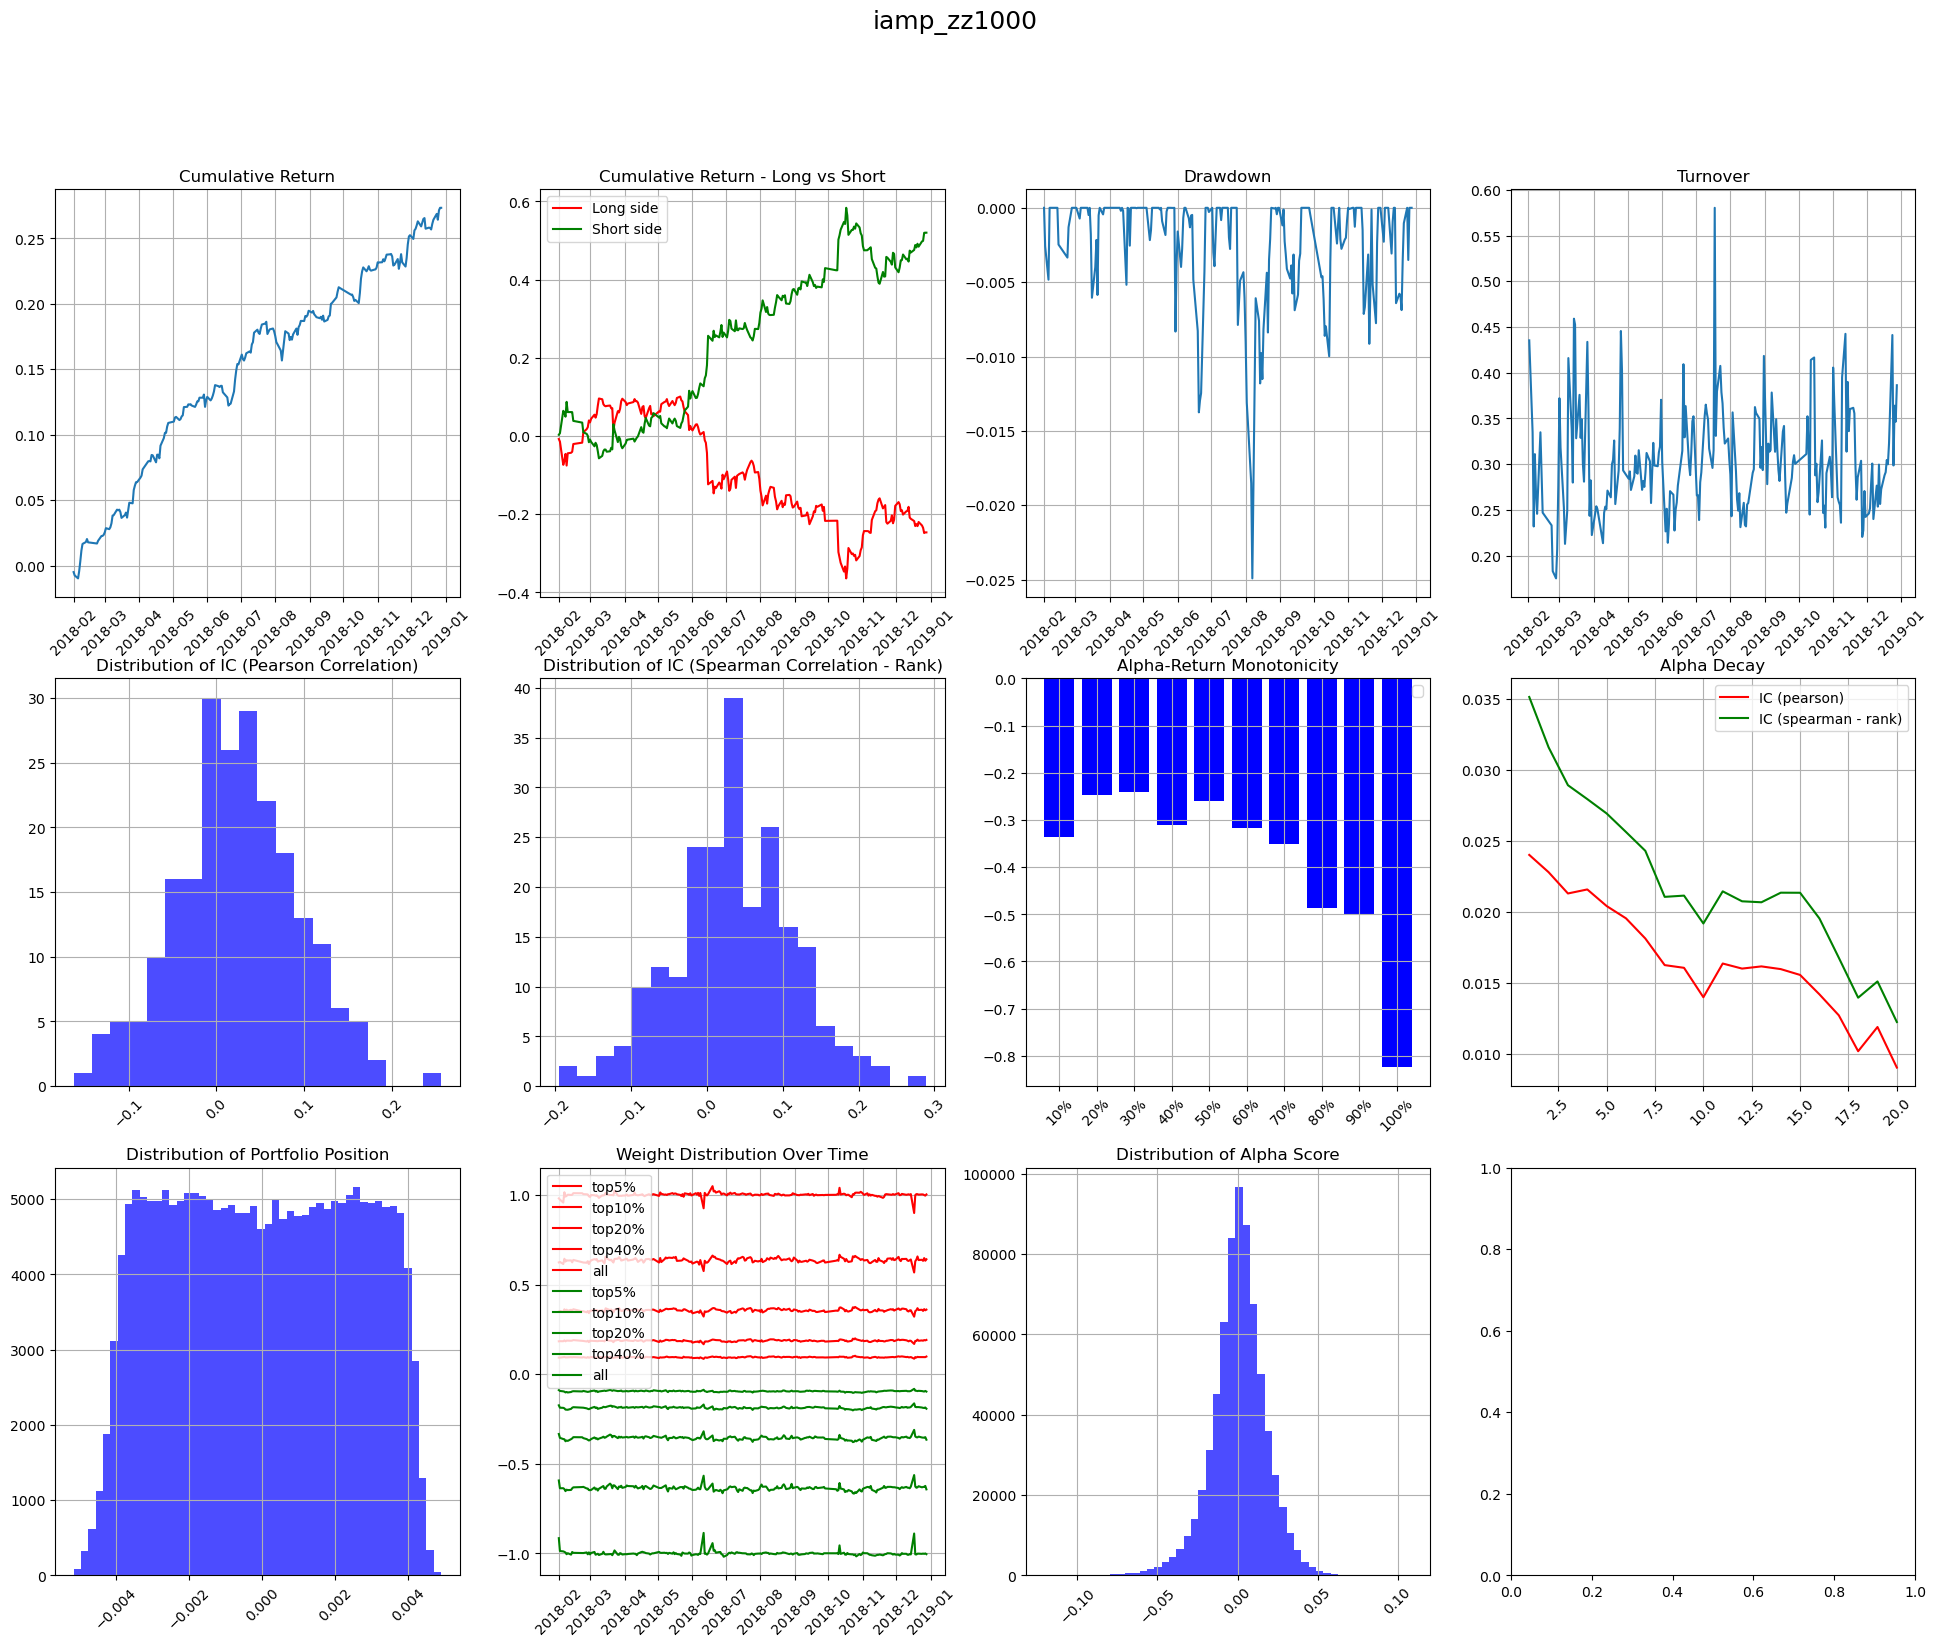

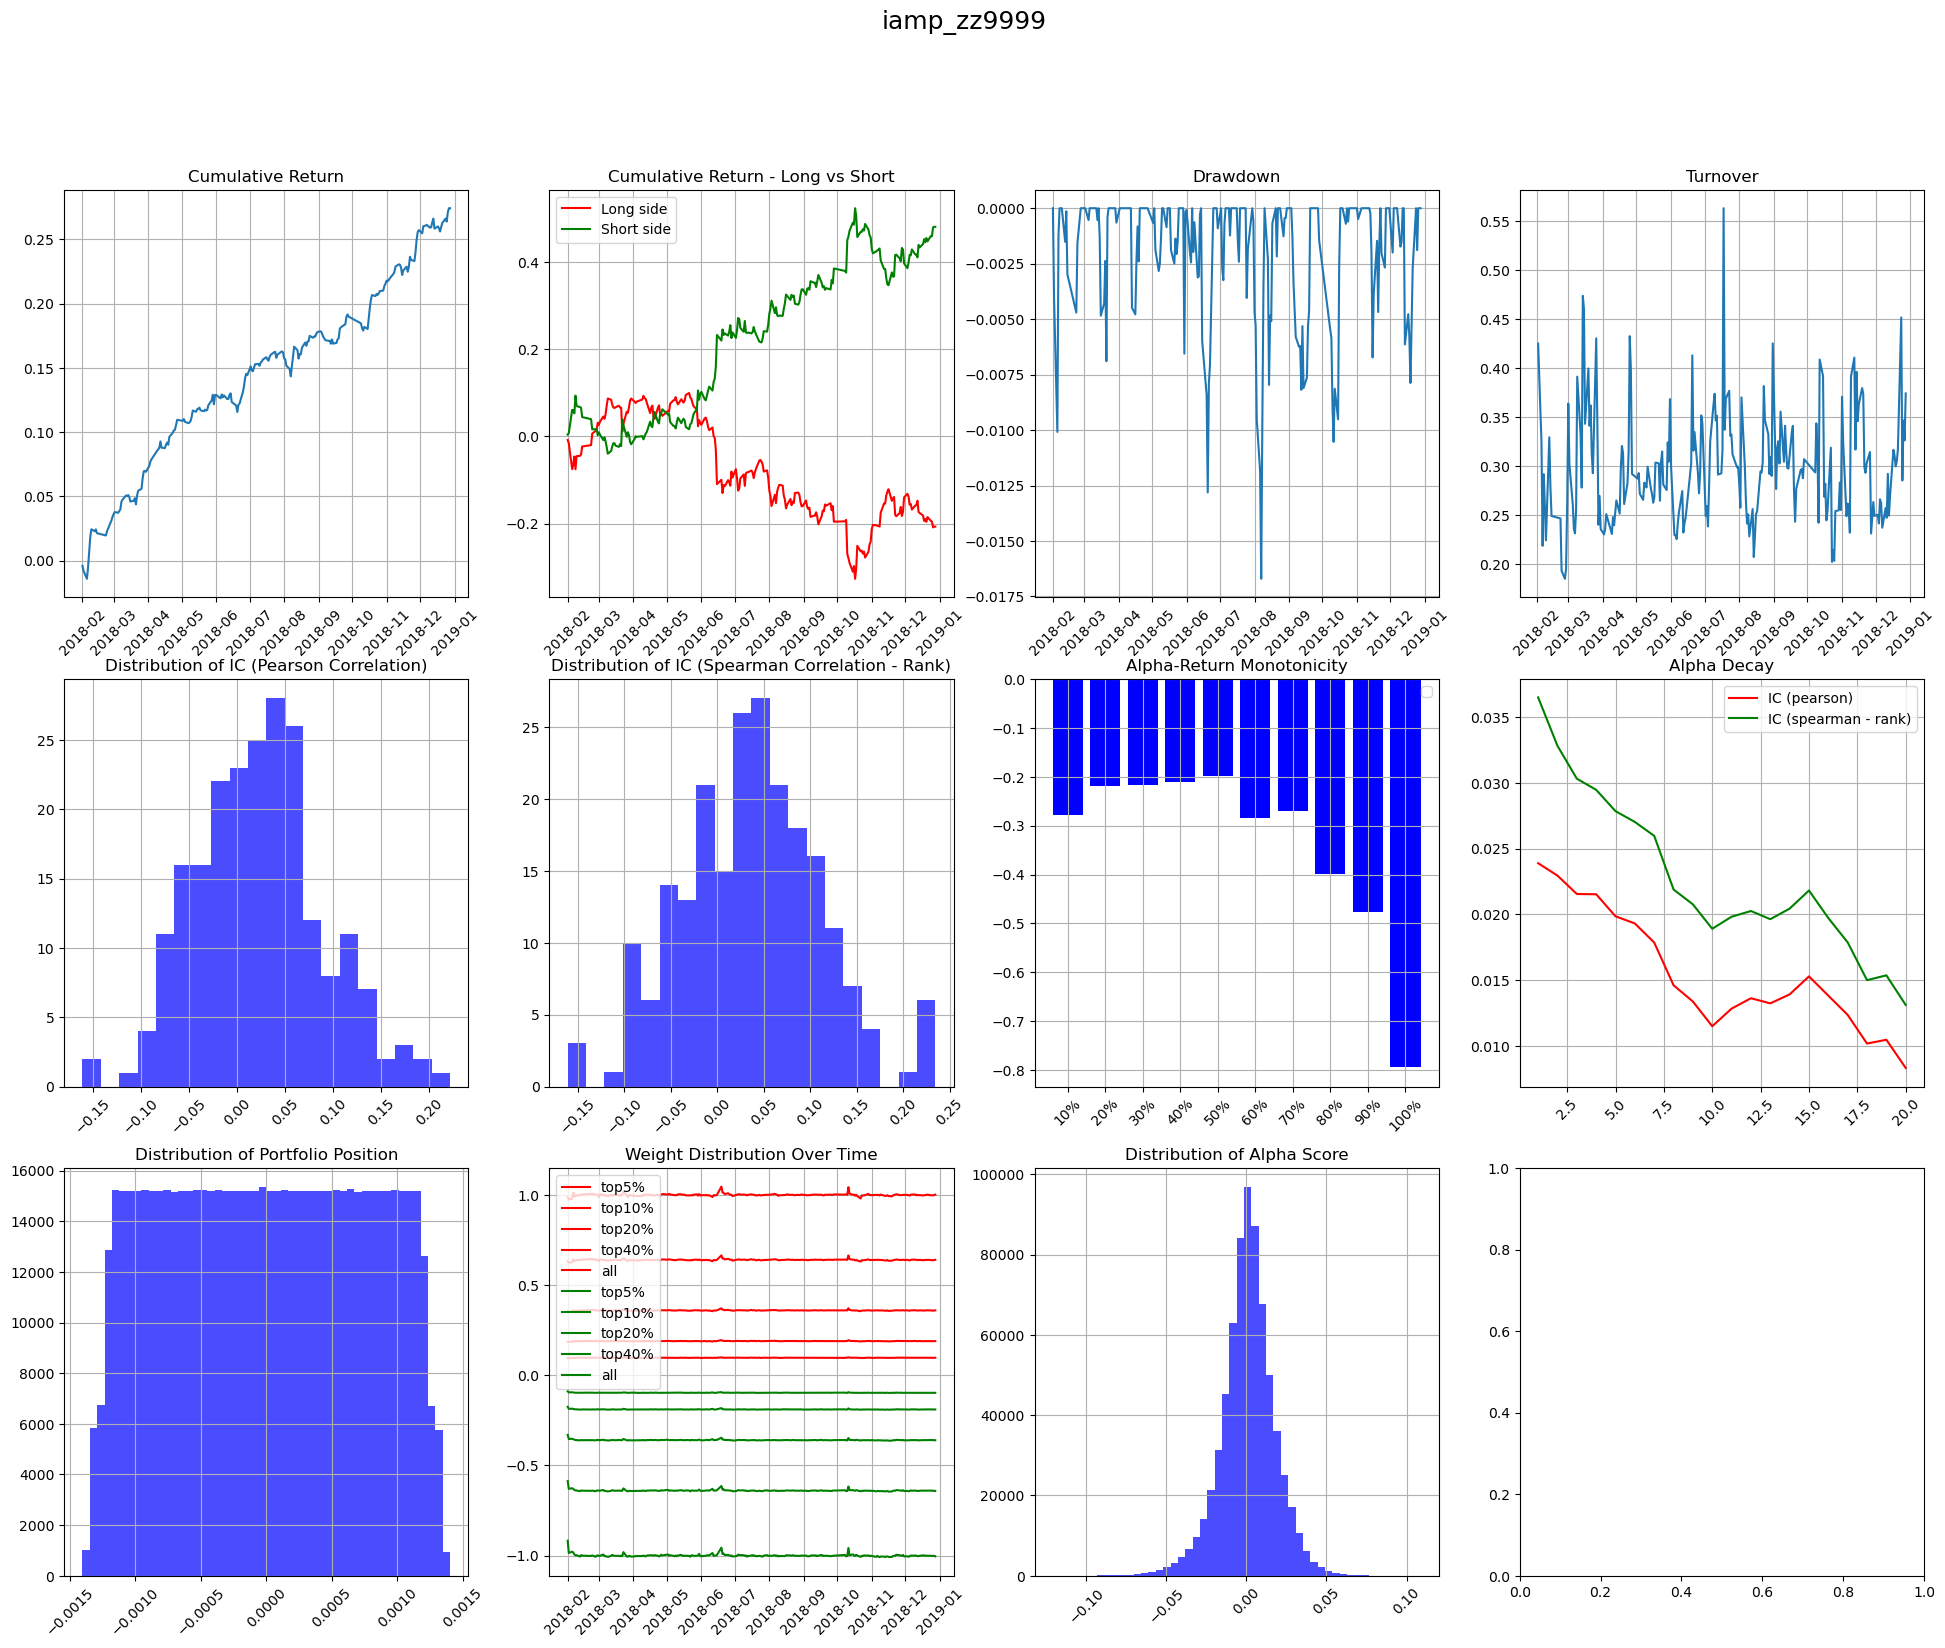

In [6]:
alpha_peformance_analyzer = AlphaPerformanceAnalyzer()
alpha_portf_name_list = ['iamp_zz9999', 'iamp_zz1000']
start = '2018-01-31'
end = '2018-12-28'
alpha_peformance_analyzer.analyze_alpha_performance(alpha_portf_name_list, start, end, is_limit_adj = True, rebalance_day = 'delay1')